## Training HMMs when hidden states are truly unobserved

In this case we use a expectation maximization (EM) algorithm. The EM algorithm is useful whenever we have to marginalize over an unknown (hidden) variable. Our likelihood is $p(x) = \sum_{z} p(x, z)$.

The E step of the EM algorithm implies computing the analogue of the counting in the case of observed $z$ s. The thing is that, now, these countings depend on $A, B, \pi, \alpha$ and $\beta$ themselves (so we actually need the forward-backward algorithms at this point). The fact that we cannot count directly is caused by the unobserved nature of the $z$ s.

E step:
$$
\xi_t(i,j) = \frac{\alpha_t(i)A_{i,j}B_{j,x_{t+1}}\beta_{t+1}(j)}{\sum_{i=1}^M\sum_{j=1}^M\alpha_t(i)A_{i,j}B_{j,x_{t+1}}\beta_{t+1}(j)}\,,\\

\gamma_t(i) = \sum_{j=1}^M \xi_t(i,j)
$$

The M step now computes $\pi, A$ and $B$ from the quantities $\xi$ and $\gamma$

M step:

$$
\pi_i = \gamma_1(i)\,,\\
A_{i,j} = \frac{\sum_{t=1}^{T-1}\xi_t(i,j)}{\sum_{t=1}^{T-1}\gamma_t(i)}\,,\\
B_{j,k} = \frac{\sum_{t=1}^{T}\gamma_t(j)\mathbb{1}(x_t=k)}{\sum_{t=1}^{T}\gamma_t(j)}\,,
$$

This is an iterative algorithm that starts from guessed values for $A$, $B$ and $\pi$ and iterates until convergence. The EM algorithm applied to HMMs (the above algorithm) is actually called `Baum-Welch` algorithm. It ensures only convergence to a *local* maximum, and so one could perform more than one training (starting from different initial points in parameter space) and keep the best final model.

## Choose the number of hidden states

When states $z$ are really unobserved, we do not know how many hidden states to choose ($M$). This needs to be treated as a hyperparameter of the model. For example, we can choose the $M$ that maximizes the log-lokelihood of the resulting model.

Another possibility is to use AIC or BIC, that choose the best model penalizing for the number of parameters (on the training set only!)

$$ AIC = 2p- 2 \log L\,,\\
BIC = p\log N -2\log L\,,
$$
where $p$ is the number of parameters. We can choose the minimum (best) AIC or BIC after evaluating on different $M$s

## Baum-Welch algorithm for multiple observations

We index each observation (each sequence) in our training set by $n$, with $n=1,..., N$. Now we will have $N$ training sequences and, for each one, we will be able to compute a $\alpha_n\,, \beta_n$. There will be also a overall probability of the sequence $P_n$ and a length that of course depends on the sequence (called $T_n$).

With this we can use the generalization of our previous formulas (now explicit in $\alpha, \beta$) as:
$$
\pi_i = \frac{1}{N}\sum_{n=1}^N \frac{\alpha_n(1,i)\beta_n(1,i)}{P_n}\,,\\
A_{ij} = \frac{\sum_{n=1}^N \frac{1}{P_n} \sum_{t=1}^{T_n-1}\alpha_n(t,i)A_{ij}B_{j, x_n(t+1)}\beta_n(t+1,j)}{\sum_{n=1}^N \frac{1}{P_n} \sum_{t=1}^{T_n-1}\alpha_n(t,i)\beta_n(t,i)}\,,\\
B_{jk} = \frac{\sum_{n=1}^N \frac{1}{P_n} \sum_{t=1}^{T_n}\alpha_n(t,j)\beta_n(t,j) \mathbb{1}(x_n(t)=k)}{\sum_{n=1}^N \frac{1}{P_n} \sum_{t=1}^{T_n}\alpha_n(t,j)\beta_n(t,j)}\,,
$$




In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Class HMM that fits the parameters and makes an inference

In [41]:
# create a valid random markov matrix
def random_normalized(dim1, dim2):
    """
    Creates a matrix of random numbers that are compatible with Markov
    (namely, they rows sum up to 1)
    """
    random_matrix = np.random.rand(dim1, dim2)
    #divide by sum over rows to make rows add up to 1 (Markov matrix)
    return random_matrix/random_matrix.sum(axis=1, keepdims=True)

In [82]:
# class HMM
class HMM:
    def __init__(self, num_hidden_states):
        self.M = num_hidden_states

    def fit(self, X: np.ndarray, max_iter: int = 30):
        """
        Parameters:
            max_iter: maximum number of EM iterations to allow
            X: stores a set of observed sequences as rows.
        """
        # include seed for reproducibility
        np.random.seed(123)

        # vocabulary size (classes from 0 to V-1)
        # (number of x states = K is the maximum number 
        # of states in the training set found for a sequence)
        vocab_size = max(max(x) for x in X) + 1 
        num_sequences = len(X)

        # initialize pi, A and B
        self.pi = np.ones(self.M)/self.M # uniform distirbution for pi
        self.A = random_normalized(self.M, self.M)
        self.B = random_normalized(self.M, vocab_size)
        print('initial values:', self.pi, self.A, self.B)
        # store cost
        costs = list()
        for it in range(max_iter):
            if it % 10 == 0:
                print('it:', it)
            alphas = list()
            betas = list()
            P = np.zeros(num_sequences) # probabilities
            # loop through observations
            for n in range(num_sequences):
                x = X[n] # n-th sequence
                T = len(x) # T_n

                #### Compute alpha[t]: forward algorithm
                alpha = np.zeros((T, self.M))
                alpha[0] = self.pi * self.B[:, x[0]]
                for t in range(1, T):
                    # * is the element by element multiplication
                    alpha[t] = alpha[t-1].dot(self.A) * self.B[:, x[t]]
                P[n] = alpha[-1].sum() # probability of a sequence
                alphas.append(alpha)

                #### Compute beta[t]: backward algorithm
                beta = np.zeros((T, self.M))
                beta[-1] = 1
                for t in range(T-2,-1,-1): # go backwards
                    beta[t] = self.A.dot(self.B[:, x[t+1]] * beta[t+1])
                betas.append(beta)

            #compute cost
            cost = np.sum(np.log(P))
            costs.append(cost)

            #### Reestimate pi, A and B
            self.pi = np.sum((alphas[n][0] * betas[n][0])/P[n] for n in range(num_sequences))/num_sequences

            denominator_1 = np.zeros((self.M,1))
            denominator_2 = np.zeros((self.M,1))
            a_num = 0
            b_num = 0
            for n in range(num_sequences):
                x = X[n] # sequence
                T = len(x) # T_n 

                denominator_1 += (alphas[n][:-1] * betas[n][:-1]).sum(axis=0, keepdims=True).T/P[n]
                denominator_2 += (alphas[n] * betas[n]).sum(axis=0, keepdims=True).T/P[n]

                # nth update for A numerator
                a_num_n = np.zeros((self.M, self.M))
                for i in range(self.M):
                    for j in range(self.M):
                        for t in range(T-1):
                            a_num_n[i,j] += alphas[n][t,i]*self.A[i,j]*self.B[j,x[t+1]] * betas[n][t+1,j]
                a_num += a_num_n/P[n]

                # nth update for B numerator
                b_num_n = np.zeros((self.M, vocab_size))
                for i in range(self.M):
                    for j in range(vocab_size):
                        for t in range(T):
                            if x[t] == j:
                                b_num_n[i,j] += alphas[n][t,i] * betas[n][t,i]
                b_num += b_num_n/P[n]

            # update A and B
            self.A = a_num/denominator_1
            self.B = b_num/denominator_2

        ## print & plot final estimates/costs
        print('ITERATION:', it)
        print("A:", self.A)
        print('check A:', self.A.sum(axis=1))
        print("B:", self.B)
        print('check B:', self.B.sum(axis=1))
        print("pi:", self.pi)
        print('check pi:', self.pi.sum())


        # plot costs
        plt.plot(costs)
        plt.show()

    def likelihood(self, x):
        '''
        Computes the probability (likelihood) of a sequence
        by means of the forwards algorithm
        '''
        T = len(x) # T_n

        #### Compute alpha[t]: forward algorithm
        alpha = np.zeros((T, self.M))
        alpha[0] = self.pi * self.B[:, x[0]]
        for t in range(1, T):
            # * is the element by element multiplication
            alpha[t] = alpha[t-1].dot(self.A) * self.B[:, x[t]]
        return alpha[-1].sum()

    def likelihood_multi(self, X):
        '''
        Computes the probability (likelihood) for all the
        observations (sequences)
        '''
        return np.array([self.likelihood(x) for x in X])

    def log_likelihood_multi(self, X):
        '''
        Computes the log likelihood of all the observations
        '''
        return np.log(self.likelihood_multi(X))

    def get_state_sequence(self, x):
        '''
        Computes the most probable set of hidden states given 
        observation sequence x using the Viterbi algorithm
        '''
        T = len(x)
        delta = np.zeros((T, self.M))
        psi = np.zeros((T, self.M))
        delta[0] = self.pi * self.B[:, x[0]]
        for t in range(1,T):
            for j in range(self.M):
                delta[t,j] = np.max(delta[t-1]*self.A[:,j])*self.B[j, x[t]]
                psi[t,j] = np.argmax(delta[t-1]*self.A[:,j])

        ### Backtrack
        states = np.zeros(T, dtype=np.int32)
        states[T-1] = np.argmax(delta[T-1])
        for t in range(T-2,-1,-1):
            states[t] = psi[t+1, states[t+1]]

        return states

Train the HMM in a dataset of sequences of coin flips with heads (`H`) or tails (`T`) generated with the following parameters:

$$
pi = (0.5,0.5).T\\
A = \begin{pmatrix}
0.1 & 0.9 \\
0.8 & 0.2 
\end{pmatrix}\\

B = \begin{pmatrix}
0.6 & 0.4\\
0.3 & 0.7
\end{pmatrix}
$$

The file is called `coin_data.txt` and can be found in 

https://github.com/lazyprogrammer/machine_learning_examples/blob/master/hmm_class/coin_data.txt

In [85]:
def fit_coin():
    '''
    Create training set from coin_data.txt file
    and fit a HMM with it
    '''
    X = list()
    for line in open('coin_data.txt'):
        x = [1 if elm == 'H' else 0 for elm in line.rstrip()]
        X.append(x)

    hmm = HMM(2)
    hmm.fit(X,max_iter=100)
    L = hmm.log_likelihood_multi(X).sum()

    print("log likelihood after fitting:", L)
    
    # set HMM to the actual values that generated the series
    # of coin flips
    hmm.pi = np.array([0.5, 0.5])
    hmm.A = np.array([[0.1, 0.9], [0.8, 0.2]])
    hmm.B = np.array([[0.6, 0.4], [0.3, 0.7]])
    L = hmm.log_likelihood_multi(X).sum()
    print("log likelihood of real generating model:", L)

    # try Viterbi on training set
    print("best state sequence for ", X[0])
    print(hmm.get_state_sequence(X[0]))

initial values: [0.5 0.5] [[0.7087962  0.2912038 ]
 [0.29152056 0.70847944]] [[0.62969057 0.37030943]
 [0.58883752 0.41116248]]
it: 0
it: 10


/tmp/ipykernel_1644/389656226.py:60: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  self.pi = np.sum((alphas[n][0] * betas[n][0])/P[n] for n in range(num_sequences))/num_sequences


it: 20
it: 30
it: 40
it: 50
it: 60
it: 70
it: 80
it: 90
ITERATION: 99
A: [[0.70371831 0.29628169]
 [0.28697428 0.71302572]]
check A: [1. 1.]
B: [[0.54110179 0.45889821]
 [0.54024348 0.45975652]]
check B: [1. 1.]
pi: [0.51003807 0.48996193]
check pi: 1.0000000000000002


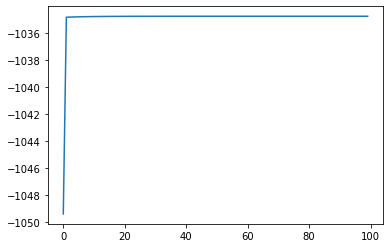

log likelihood after fitting: -1034.7539242965554
log likelihood of real generating model: -1059.7229160265022
best state sequence for  [0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1]
[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]


In [86]:
fit_coin()

The problem with the above algorithms is *underflow*: after all, $\alpha$ and $\beta$ are small numbers ($<1$) and hence, for long sequences, the training algorithm will lead to zero for $\alpha$ really soon, meaning that all multiplications will be zero from that point on. To solve this issue, we will do the following:

- For the Viterbi algorithm we will use logs, since it only involve multiplications. Hence, we turn the multiplications into sums and avoid the underflow problem.

- For the Baum-Welch algorithm, we will use scaling. For this, we will use a scale factor $c_t\,, t=1,...,T$